In [4]:
import numpy as np
import pandas as pd

from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from owlready2 import *

import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image



In [5]:
onto = get_ontology("doid.owl").load()

In [6]:
def pd_fill_diagonal(df_matrix, value=0): 
    mat = df_matrix.values
    n = mat.shape[0]
    mat[range(n), range(n)] = value
    return pd.DataFrame(mat)

In [7]:
cos = pd_fill_diagonal(np.round(pd.read_csv("cos_dsims.csv",index_col=[0]),decimals=10))
wang = pd_fill_diagonal(np.round(pd.read_csv("wang_dsims.csv",index_col=[0]),decimals=10))
bins = pd.read_csv("binary_with_index.csv",index_col=[0])
comb_idx = pd.read_csv("comb_idx.csv", index_col=[0])

# Disease Names

In [9]:
disease_name = {i:onto.search(iri = "*_"+i)[0].label[0] for i in bins.columns[:-1]}

In [10]:
name_idx = {i:comb_idx.to_dict()['0'][i].replace("[","").replace("]","").replace("'","").split(",") for i in comb_idx.to_dict()['0']}
name_idx = {i:[disease_name[j.strip()] for j in name_idx[i] if j != ''] for i in name_idx}

In [11]:
pd.Series(name_idx)

0       [respiratory syncytial virus infectious disease]
1      [diabetes mellitus, respiratory syncytial viru...
2      [obesity, respiratory syncytial virus infectio...
3                                    [diabetes mellitus]
4      [diabetes mellitus, obesity, respiratory syncy...
                             ...                        
460    [brain disease, skin cancer, respiratory syncy...
461    [obsolete impaired renal function disease, imm...
462    [obsolete impaired renal function disease, uri...
463    [obsolete impaired renal function disease, hum...
464    [diabetes mellitus, acute myocardial infarctio...
Length: 465, dtype: object

In [12]:
pd.DataFrame({i:name_idx[i]+['' for j in range(10-len(name_idx[i]))] for i in name_idx}).T.to_csv('disease_names.csv')

# KMedoids

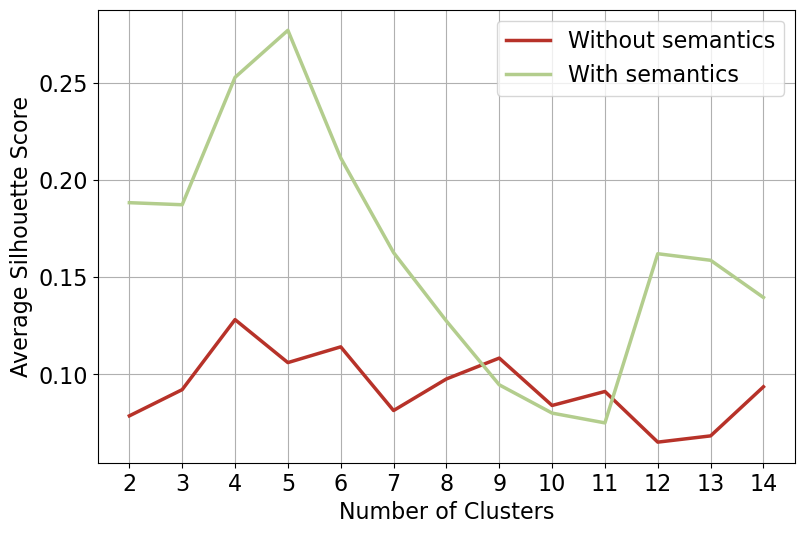

In [14]:
metrics = pd.DataFrame(data=0, index=range(2,15), columns = ["no-semantics","semantics"])
metrics.index.rename("Number of Clusters",inplace = True)

for k in range(2,15):
    kmedoids_c = KMedoids(n_clusters=k, random_state=42, metric = 'precomputed').fit(cos)
    kmedoids_w = KMedoids(n_clusters=k, random_state=42, metric = 'precomputed').fit(wang)
    metrics.loc[k,["no-semantics","semantics"]] = [silhouette_score(cos,kmedoids_c.labels_,metric='precomputed'),silhouette_score(wang,kmedoids_w.labels_,metric='precomputed')]

    
fig, ax = plt.subplots(figsize=(9,6),dpi=100)

ax.plot(metrics["no-semantics"],
         label = "Without semantics",
         linewidth=2.5,
         color=(183/255,50/255,41/255))

ax.plot(metrics["semantics"],
         label = "With semantics",
         linewidth=2.5,
         color=(179/255,205/255,141/255))

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(range(2,15))

ax.xaxis.grid(True)
ax.yaxis.grid(True)

ax.set_xlabel("Number of Clusters",fontsize=16)
ax.set_ylabel("Average Silhouette Score",fontsize=16)
leg = ax.legend(prop={"size":16})

plt.show()

In [15]:
metrics

,no-semantics,semantics
Number of Clusters,,
2,0.078589,0.188358
3,0.092092,0.187294
4,0.128143,0.252884
5,0.106014,0.277108
6,0.114129,0.211390
7,0.081332,0.162660
8,0.097591,0.127424
9,0.108334,0.094579
10,0.083941,0.080015


In [16]:
kmedoids_c = KMedoids(n_clusters=4, random_state=42, metric = 'precomputed').fit(cos)
kmedoids_w = KMedoids(n_clusters=5, random_state=42, metric = 'precomputed').fit(wang)

In [17]:
kmedoids_w.medoid_indices_

array([ 96, 416,   9,   1, 340])

In [12]:
kmedoids_c.medoid_indices_

array([14,  7,  2, 20])

In [18]:
semantic_centers = {i:name_idx[i] for i in kmedoids_w.medoid_indices_}
no_semantic_centers = {i:name_idx[i] for i in kmedoids_c.medoid_indices_}

In [19]:
sil_cos = (pd.DataFrame(data={'cluster':kmedoids_c.labels_,
                              'silhouette':silhouette_samples(cos,
                                                              kmedoids_c.labels_,
                                                              metric='precomputed')}).sort_values(['cluster','silhouette'],
                                                              ascending=[True,False])).reset_index()

sil_cos['name'] = sil_cos['index'].map(name_idx)

sil_wang = (pd.DataFrame(data={'cluster':kmedoids_w.labels_,
                               'silhouette':silhouette_samples(wang,
                                                               kmedoids_w.labels_,
                                                               metric='precomputed')}).sort_values(['cluster','silhouette'],
                                                               ascending=[True,False])).reset_index()
sil_wang['name'] = sil_cos['index'].map(name_idx)

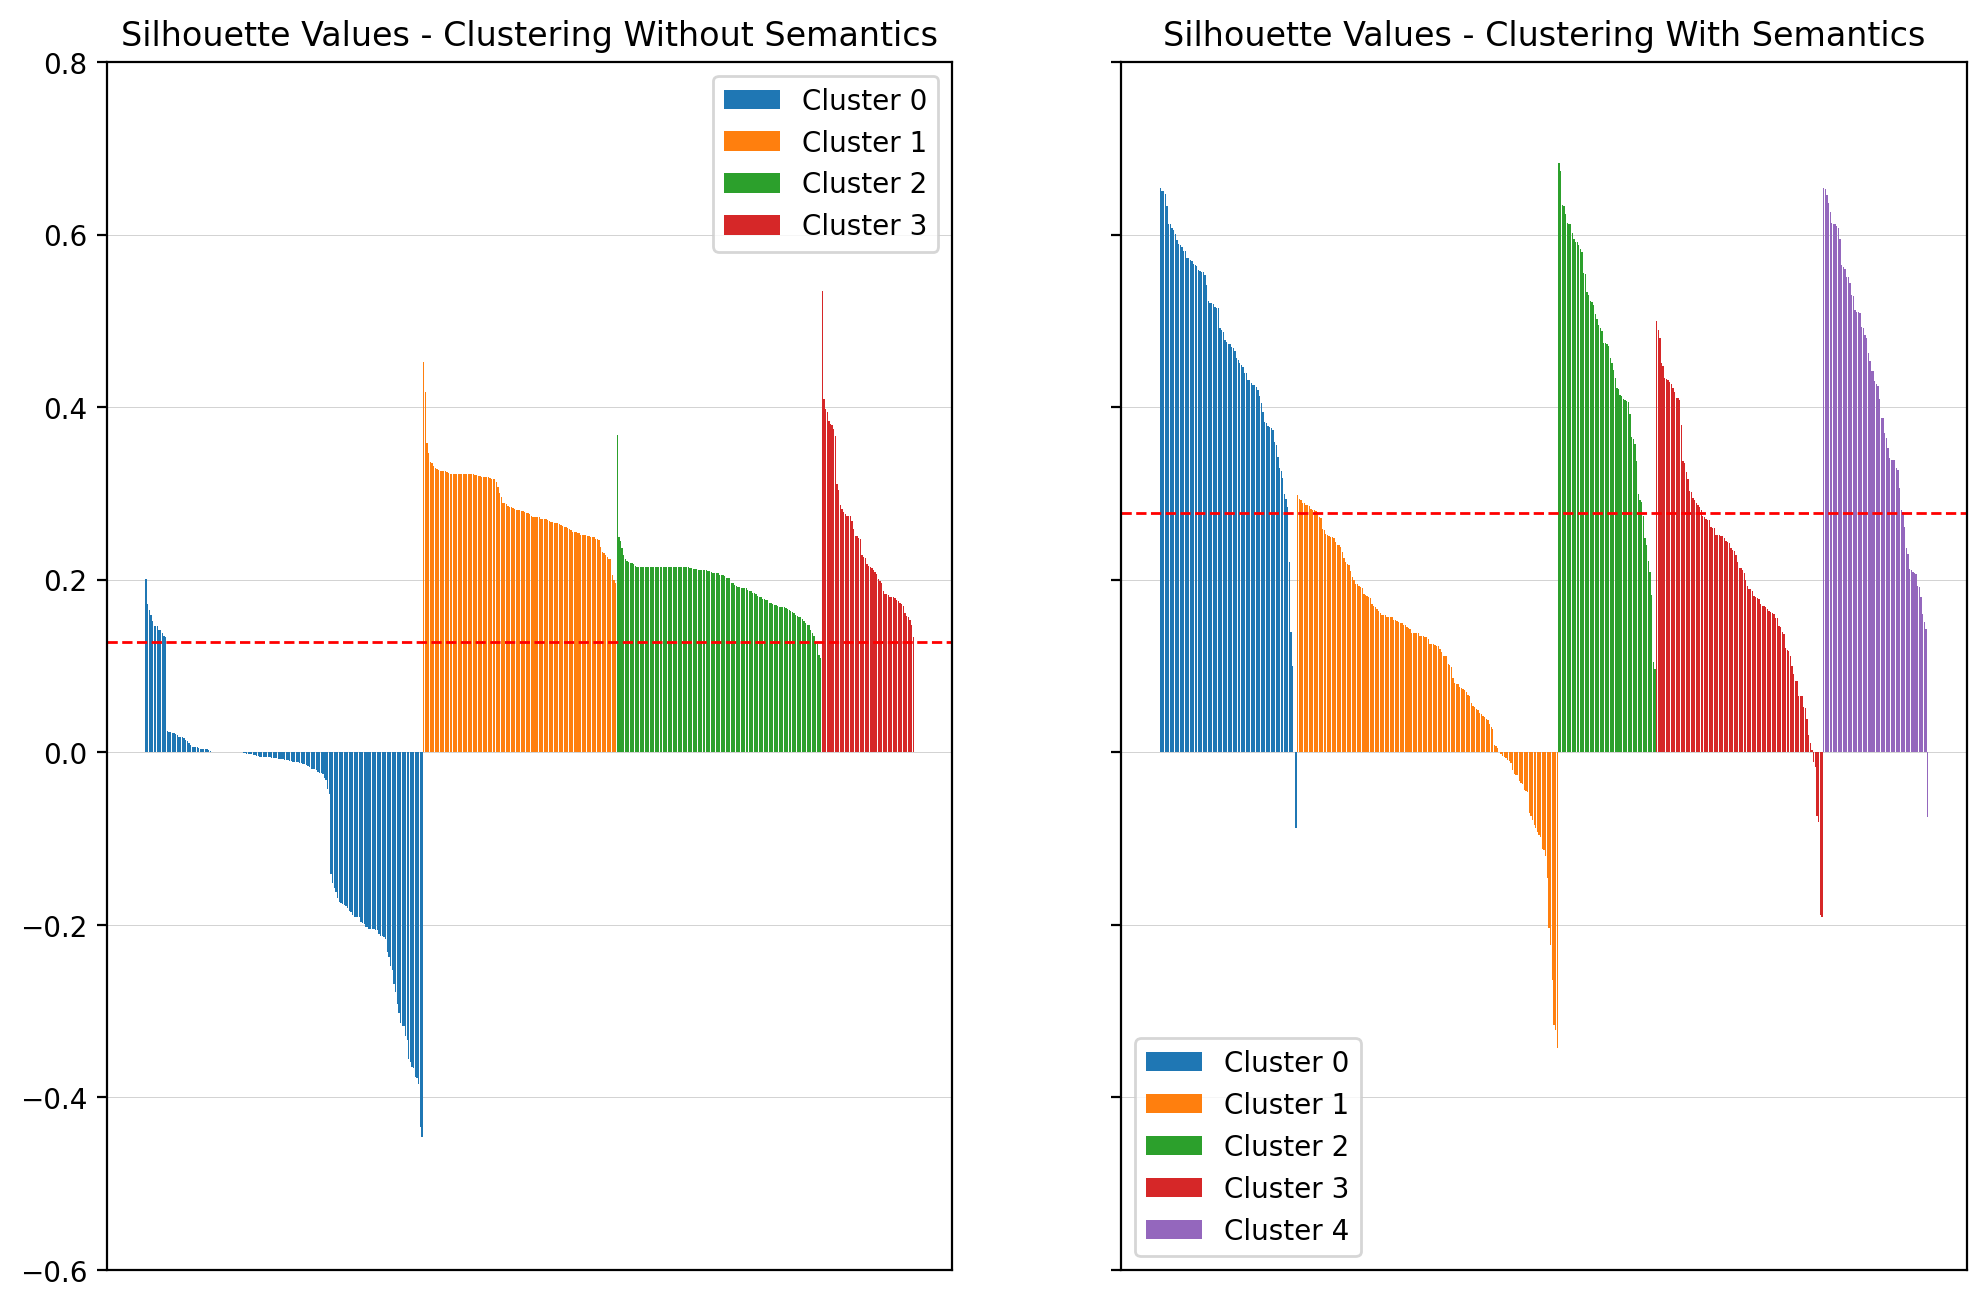

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,8),dpi=200,sharey=True)

ax[0].grid(axis='y',linewidth = 0.2)
ax[1].grid(axis='y',linewidth = 0.2)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

for k in sil_cos['cluster'].unique():

    ax[0].bar(x = sil_cos[sil_cos['cluster'] == k].index,
              height = sil_cos[sil_cos['cluster'] == k]['silhouette'],
              label = 'Cluster %i'%k)
    ax[0].legend()
    

ax[0].axhline(sil_cos['silhouette'].mean(),
              color = 'red',
              linestyle = '--',
              linewidth = 1.0,
              label = k)



for k in sil_wang['cluster'].unique():

    ax[1].bar(x = sil_wang[sil_wang['cluster'] == k].index,
              height = sil_wang[sil_wang['cluster'] == k]['silhouette'],
              label = 'Cluster %i'%k)
    ax[1].legend()
    

ax[1].axhline(sil_wang['silhouette'].mean(),
              color = 'red',
              linestyle = '--',
              linewidth = 1.0)

ax[1].set_yticks(ax[0].get_yticks())



ax[0].set_xticks([])
ax[1].set_xticks([])


ax[0].set_title('Silhouette Values - Clustering Without Semantics')
ax[1].set_title('Silhouette Values - Clustering With Semantics')


plt.savefig("Silhouettes Values.svg")
plt.show()

In [17]:
cos['cluster'] = kmedoids_c.labels_
wang['cluster'] = kmedoids_w.labels_

In [18]:
wang['cluster'].to_csv('semantic_clusters.csv')
cos['cluster'].to_csv('no_semantic_clusters.csv')

In [20]:
sil_cos.to_csv('cos_sil_and_names.csv')
sil_wang.to_csv('wang_sil_and_names.csv')